In [124]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pysam
import re

In [3]:
ALIGNMENT_FILE = "lact.bam"
GENOME_LENGTH = 3079196

In [4]:
def write_to_wigfile(wigfile_header, wigfile_values, file_name):
    wigfile_content = wigfile_header + "\n"
    
    for wigfile_value in wigfile_values:
        wigfile_content += wigfile_value + "\n"
    
    with open(file_name, 'w') as the_file:
        the_file.write(wigfile_content)

In [5]:
# Physical coverage

def physical_coverage(samfile):
    genome_change = [0] * GENOME_LENGTH
    for read in samfile:
        # Check for left mate pair and SAM flags: 0x1 and 0x2
        if (read.template_length > 0 and read.is_paired and read.is_proper_pair):
            genome_change[read.reference_start] += 1
            genome_change[read.reference_start + read.template_length] -= 1


    current_coverage = 0
    physical_coverage_values = []

    for position in range(GENOME_LENGTH):
        current_coverage += genome_change[position]
        physical_coverage_values.append(current_coverage)

    return physical_coverage_values

In [6]:
samfile = pysam.AlignmentFile(ALIGNMENT_FILE)

physical_coverage_values = physical_coverage(samfile)

write_to_wigfile(wigfile_header="fixedStep chrom=genome start=1 step=1 span=1", 
                     wigfile_values=list(map(str, physical_coverage_values)),
                     file_name="physical_coverage.wig")

In [7]:
# Sequence coverage

def sequence_coverage(samfile):
    genome_change = [0] * GENOME_LENGTH
    for read in samfile:
        # Check for SAM flags: 0x1 and 0x2
        if (read.is_paired and read.is_proper_pair):
            genome_change[read.reference_start] += 1
            genome_change[read.reference_end] -= 1


    current_coverage = 0
    sequence_coverage_values = []

    for position in range(GENOME_LENGTH):
        current_coverage += genome_change[position]
        sequence_coverage_values.append(current_coverage)
        
    return sequence_coverage_values

In [8]:
samfile = pysam.AlignmentFile(ALIGNMENT_FILE)

sequence_coverage_values = sequence_coverage(samfile)

write_to_wigfile(wigfile_header="fixedStep chrom=genome start=1 step=1 span=1", 
                     wigfile_values=list(map(str, sequence_coverage_values)),
                     file_name="sequence_coverage.wig")

In [59]:
# Lengths of genomic insert
samfile = pysam.AlignmentFile(ALIGNMENT_FILE)

insert_lengths = []
for read in samfile:
    # Check for left mate pair and SAM flags: 0x1 and 0x2
    if (read.template_length > 0 and read.is_paired and read.is_proper_pair):
        insert_lengths.append(read.template_length)

In [60]:
lengths_mean = np.mean(insert_lengths)
lengths_std = np.std(insert_lengths)

print("Lengths mean is: " + str(lengths_mean))
print("Lengths std is: " + str(lengths_std))

Lengths mean is: 2101.273492569815
Lengths std is: 205.45154594269033


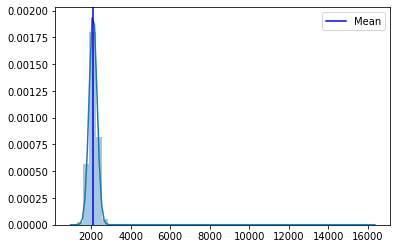

In [61]:
sns.distplot(insert_lengths)
plt.axvline(lengths_mean, color='b', linestyle='-')
plt.legend({'Mean': lengths_mean})

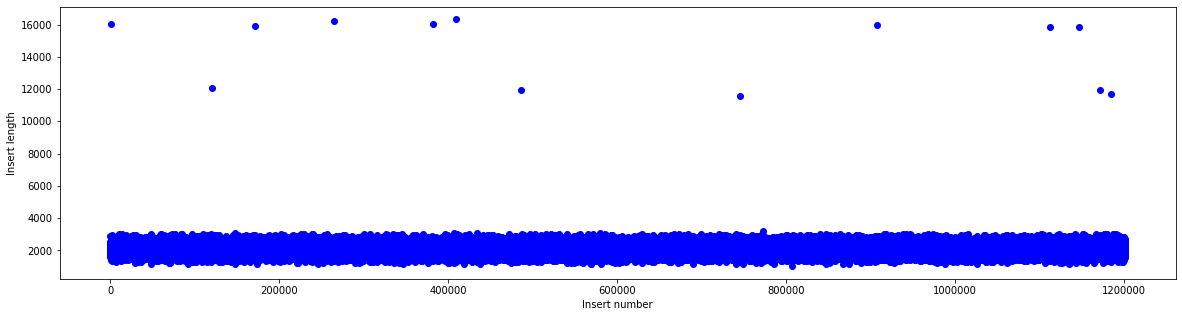

In [62]:
plt.figure(figsize=(20,5))
plt.plot(insert_lengths, "bo")

plt.xlabel('Insert number')
plt.ylabel('Insert length')

plt.show()

In [63]:
# Discard outliers

# convert to np array for convenience
insert_lengths = np.array(insert_lengths)

# Outlier is the insert length > 10.000
outliers = np.where(insert_lengths > 10000)[0]

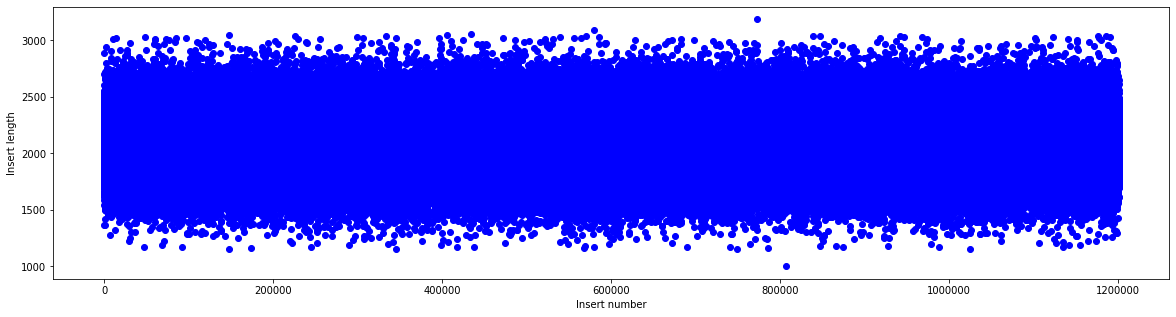

In [64]:
insert_lengths_without_outliers = np.delete(insert_lengths, outliers)

plt.figure(figsize=(20,5))
plt.plot(insert_lengths_without_outliers, "bo")

plt.xlabel('Insert number')
plt.ylabel('Insert length')

plt.show()

In [65]:
lengths_mean_without_outliers = np.mean(insert_lengths_without_outliers)
lengths_std_without_outliers = np.std(insert_lengths_without_outliers)

print("Lengths mean is: " + str(lengths_mean_without_outliers))
print("Lengths std is: " + str(lengths_std_without_outliers))

Lengths mean is: 2101.140261033228
Lengths std is: 201.30898238022633


In [208]:
# Average length of the physical inserts track (for each bp)

def average_insert_length(samfile):
    physical_coverage_values = np.array(physical_coverage(samfile))

    # reset iterable to start from the beginning
    samfile = pysam.AlignmentFile(ALIGNMENT_FILE)

    insert_length_sums = np.zeros(3079196)

    for read in samfile:
        # Check for left mate pair and SAM flags: 0x1 and 0x2
        if (read.template_length > 0 and read.is_paired and read.is_proper_pair):
            insert_length_sums[read.reference_start: (read.reference_start + read.template_length)] += read.template_length

    average_length_per_base = insert_length_sums / physical_coverage_values
    average_length_per_base[np.isnan(average_length_per_base)] = 0

    return average_length_per_base

In [209]:
samfile = pysam.AlignmentFile(ALIGNMENT_FILE)

average_insert_length_values = average_insert_length(samfile)

write_to_wigfile(wigfile_header="fixedStep chrom=genome start=1 step=1 span=1", 
                     wigfile_values=list(map(str, average_insert_length_values)),
                     file_name="average_insert_length.wig")

/Users/neil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/Users/neil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [226]:
# Track with the percentage of inserts with a length exceeding n standard deviations (n=2) above or below the mean

def unusual_inserts(samfile):
    number_of_unusual_inserts = np.zeros(3079196)
    range_of_usual_inserts = range(int(lengths_mean - 2 * lengths_std), int(lengths_mean + 2 * lengths_std))
    
    for read in samfile:
        # Check for left mate pair and SAM flags: 0x1 and 0x2
        if (read.template_length > 0 and read.is_paired and read.is_proper_pair):
            number_of_unusual_inserts[read.reference_start: (read.reference_start + read.template_length)] += read.template_length not in range_of_usual_inserts

    # reset iterable to start from the beginning
    samfile = pysam.AlignmentFile(ALIGNMENT_FILE)
    
    physical_coverage_values = np.array(physical_coverage(samfile))
            
    percentage_of_unusual_inserts = number_of_unusual_inserts / physical_coverage_values
    percentage_of_unusual_inserts[np.isnan(percentage_of_unusual_inserts)] = 0
    
    return percentage_of_unusual_inserts

In [227]:
samfile = pysam.AlignmentFile(ALIGNMENT_FILE)

unusual_insert_values = unusual_inserts(samfile)

write_to_wigfile(wigfile_header="fixedStep chrom=genome start=1 step=1 span=1", 
                     wigfile_values=list(map(str, unusual_insert_values)),
                     file_name="unusual_inserts.wig")

/Users/neil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/neil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


In [230]:
# Unique reads - reads with MAPQ value != 0

def unique_reads(samfile):
    genome_change = [0] * GENOME_LENGTH
    
    for read in samfile:
        # Check for MAPQ != 0 (unique read) SAM flags: 0x1 and 0x2
        if (read.mapping_quality != 0 and read.is_paired and read.is_proper_pair):
            genome_change[read.reference_start] += 1
            genome_change[read.reference_end] -= 1


    current_coverage = 0
    sequence_coverage_values = []

    for position in range(GENOME_LENGTH):
        current_coverage += genome_change[position]
        sequence_coverage_values.append(current_coverage)
        
    return sequence_coverage_values

In [231]:
samfile = pysam.AlignmentFile(ALIGNMENT_FILE)

unique_reads_coverage = unique_reads(samfile)

write_to_wigfile(wigfile_header="fixedStep chrom=genome start=1 step=1 span=1", 
                     wigfile_values=list(map(str, unique_reads_coverage)),
                     file_name="unique_reads_coverage.wig")

In [232]:
# Multiple reads (Ambiguous reads) - reads with MAPQ value = 0

def multiple_reads(samfile):
    genome_change = [0] * GENOME_LENGTH
    
    for read in samfile:
        # Check for MAPQ == 0 SAM flags: 0x1 and 0x2
        if (read.mapping_quality == 0 and read.is_paired and read.is_proper_pair):
            genome_change[read.reference_start] += 1
            genome_change[read.reference_end] -= 1


    current_coverage = 0
    sequence_coverage_values = []

    for position in range(GENOME_LENGTH):
        current_coverage += genome_change[position]
        sequence_coverage_values.append(current_coverage)
        
    return sequence_coverage_values

In [233]:
samfile = pysam.AlignmentFile(ALIGNMENT_FILE)

multiple_reads_coverage = multiple_reads(samfile)

write_to_wigfile(wigfile_header="fixedStep chrom=genome start=1 step=1 span=1", 
                     wigfile_values=list(map(str, multiple_reads_coverage)),
                     file_name="multiple_reads_coverage.wig")

In [108]:
# https://www.biostars.org/p/14379/
# https://www.cureffi.org/2012/12/19/forward-and-reverse-reads-in-paired-end-sequencing/

# Strange result - write why (TODO)

def oriented_mates_test(samfile):    
    # FR aligned - left mate pair is on the forward strand. right mate pair is on the reverse strand
    count_FR = 0
    
    # RF aligned = left mate pair is on the reverse strand. right mate pair is on the forward strand
    count_RF = 0
    
    # on the same strand - RR
    count_RR = 0
    
    # on the same strand - FF
    count_FF = 0
    
    for read in samfile:
        # Check for left mate pair and SAM flags: 0x1 and 0x4
        if read.template_length > 0 and read.is_paired and not read.is_unmapped:
            if not read.is_reverse and read.mate_is_reverse:
                # what it should be for proper pair. left mate is on forward strand (5' -> 3') and
                # right pair is on the reverse strand (3' -> 5') but reading from the 5' end
                # also called FR alignment
                count_FR += 1
            elif read.is_reverse and not read.mate_is_reverse:
                count_RF += 1
            elif not read.is_reverse and not read.mate_is_reverse:
                count_FF += 1
            else:
                count_RR += 1


    print(f"FR: {count_FR}")
    print(f"RF: {count_RF}")
    print(f"RR: {count_RR}")
    print(f"FF: {count_FF}")

In [109]:
samfile = pysam.AlignmentFile(ALIGNMENT_FILE)
oriented_mates_test(samfile)

FR: 5992
RF: 5842
RR: 598100
FF: 614749


In [236]:
# Track with percentage of single mates

def single_mates(samfile): 
    genome_change = [0] * GENOME_LENGTH
    
    for read in samfile:
        # Check for SAM flags: 0x1, 0x4 and 0x8
        if (read.is_paired and not read.is_unmapped and read.mate_is_unmapped):
            genome_change[read.reference_start] += 1
            genome_change[read.reference_end] -= 1

    current_coverage = 0
    single_mate_coverage_values = []

    for position in range(GENOME_LENGTH):
        current_coverage += genome_change[position]
        single_mate_coverage_values.append(current_coverage)
    
    # reset iterable to start from the beginning
    samfile = pysam.AlignmentFile(ALIGNMENT_FILE)
    sequence_coverage_values = np.array(sequence_coverage(samfile))
    
    single_mates_percent = np.array(single_mate_coverage_values) / np.array(sequence_coverage_values)
    single_mates_percent[np.isnan(single_mates_percent)] = 0
    
    return single_mates_percent

In [237]:
samfile = pysam.AlignmentFile(ALIGNMENT_FILE)

single_mates_percent_values = single_mates(samfile)

write_to_wigfile(wigfile_header="fixedStep chrom=genome start=1 step=1 span=1", 
                     wigfile_values=list(map(str, single_mates_percent_values)),
                     file_name="single_mates_percent.wig")

# here output values can be greater than 1 (100%). 
# Such outputs mean that there are more single reads at this position than proper paired reads

/Users/neil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/Users/neil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


In [187]:
# 1 - for gene on forward strand
# -2 - for gene on reverse strand
# -1 - if genes on forward and reverse strands overlap

# ATG - start codon
# TAA, TAG, TGA - stop codons

def gene_predictions(samfile):
    
    genome_change_forward = [0] * GENOME_LENGTH
    genome_change_reverse = [0] * GENOME_LENGTH
    
    for read in samfile:
        # Check for SAM flags: 0x1 and 0x2
        if read.is_paired and read.is_proper_pair:
            read_seq = read.get_reference_sequence().upper()
            
            start_codon_positions = [m.start() for m in re.finditer("ATG", read_seq)]
            stop_codon_positions = [m.start() for m in re.finditer("(TAA|TAG|TGA)", read_seq)]
            
            if not read.is_reverse:
                # Forward strand
                
                # Marking start codons in the genome
                for start_codon_pos in start_codon_positions:
                    genome_change_forward[read.reference_start + start_codon_pos] = 1
            
                # Marking stop codons in the genome
                for stop_codon_pos in stop_codon_positions:
                    genome_change_forward[read.reference_start + stop_codon_pos] = -1
            else:
                # Reverse strand
                
                # Marking start codons in the genome
                for start_codon_pos in start_codon_positions:
                    genome_change_reverse[read.reference_start + start_codon_pos] = 1
                    
                # Marking stop codons in the genome
                for stop_codon_pos in stop_codon_positions:
                    genome_change_reverse[read.reference_start + stop_codon_pos] = -1
                    
    
    gene_predictions = np.zeros(GENOME_LENGTH)

    orf_start_position = 0        
    search_for_stop = False

    # Forward strand
    for position in range(GENOME_LENGTH):
        if genome_change_forward[position] == 1 and not search_for_stop:
            orf_start_position = position
            search_for_stop = True

        if genome_change_forward[position] == -1 and search_for_stop:
            search_for_stop = False

            if position - orf_start_position > 300:
                gene_predictions[orf_start_position:position] = 1

    orf_start_position = 0        
    search_for_stop = False

    # Reverse strand
    for position in range(GENOME_LENGTH):
        if genome_change_reverse[position] == 1 and not search_for_stop:
            orf_start_position = position
            search_for_stop = True

        if genome_change_reverse[position] == -1 and search_for_stop:
            search_for_stop = False

            if position - orf_start_position > 300:
                gene_predictions[orf_start_position:position] = -2


    return gene_predictions

In [139]:
samfile = pysam.AlignmentFile(ALIGNMENT_FILE)

gene_prediction_values = gene_predictions(samfile)

write_to_wigfile(wigfile_header="fixedStep chrom=genome start=1 step=1 span=1", 
                     wigfile_values=list(map(str, gene_prediction_values)),
                     file_name="gene_predictions.wig")

# NO GENES FOUND!